## Cal-CRAI Metric Calculation for: Climate Risk / extreme heat warnings
* Median annual number of days with excessive heat warnings

In [1]:
import geopandas as gpd
import s3fs
import pandas as pd
import boto3
import dask_geopandas
import dask.dataframe as dd
import matplotlib.pyplot as plt
import os
import sys
import numpy as np

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import upload_csv_aws, pull_gpkg_from_directory
from scripts.utils.write_metadata import append_metadata

### Retrieve data

In [2]:
# pull gpkg data from AWS
bucket_name = 'ca-climate-index'
aws_dir = '2b_reproject/climate_risk/extreme_heat/exposure/iowa_state_environmental_mesonet/'

pull_gpkg_from_directory(bucket_name, aws_dir)

Saved GeoPackage as 'climate_iowa_mesonet_heat_warnings.gpkg' locally


In [3]:
heat_warnings_data = gpd.read_file('climate_iowa_mesonet_heat_warnings.gpkg')
heat_warnings_data.columns
heat_warnings_data = heat_warnings_data[['ISSUED', 'USCB_GEOID', 'geometry']]

In [4]:
heat_warnings_data = heat_warnings_data[['ISSUED', 'USCB_GEOID', 'geometry']]
heat_warnings_data

,ISSUED,USCB_GEOID,geometry
0,200607151700,06083001800,"POLYGON ((-119.46000 34.80000, -119.48000 34.8..."
1,200607151700,06083001800,"MULTIPOLYGON (((-119.94000 34.66000, -119.9400..."
2,200607151700,06083001800,"MULTIPOLYGON (((-119.47000 34.90000, -119.4800..."
3,200607151700,06083001800,"POLYGON ((-119.72000 34.52000, -119.63000 34.5..."
4,200607221900,06083001800,"MULTIPOLYGON (((-119.47000 34.90000, -119.4800..."
...,...,...,...
225419,202106162100,06063000100,"POLYGON ((-121.03772 39.94961, -121.03771 39.9..."
225420,202107091900,06063000100,"POLYGON ((-121.03772 39.94961, -121.03771 39.9..."
225421,202207281800,06063000100,"POLYGON ((-121.03772 39.94961, -121.03771 39.9..."
225422,202209041800,06063000100,"POLYGON ((-121.03772 39.94961, -121.03771 39.9..."


### Clean and count the number of warning days

In [5]:
def clean_warnings(df):
    # reduce by counting the # of events per tract:
    # shave off time issued so we only have days    
    df['ISSUED_day'] = df['ISSUED'].str.slice(0,8)
    df = df.drop_duplicates(subset=['ISSUED_day', 'USCB_GEOID'], keep='first')
    df['ISSUED_year'] = df['ISSUED'].str.slice(0,4)
    
    df_out = df.groupby(['USCB_GEOID','ISSUED_day', 'ISSUED_year'])['ISSUED'].count().reset_index().rename(columns={'ISSUED':'number_warnings'})
    return df_out

df_cleaned = clean_warnings(heat_warnings_data)
df_cleaned

c:\Users\jespi\miniconda3\envs\carb\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,USCB_GEOID,ISSUED_day,ISSUED_year,number_warnings
0,06001400100,20080515,2008,1
1,06001400100,20080708,2008,1
2,06001400100,20101012,2010,1
3,06001400100,20130629,2013,1
4,06001400100,20170621,2017,1
...,...,...,...,...
203349,06115041102,20210616,2021,1
203350,06115041102,20210709,2021,1
203351,06115041102,20220904,2022,1
203352,06115041102,20230630,2023,1


In [6]:
# count the number of days per year
dfg = df_cleaned.groupby(['USCB_GEOID', 'ISSUED_year']).count()
dfg = dfg = dfg.drop(columns='ISSUED_day').unstack()
dfg

number_warnings                                                    \
ISSUED_year            2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016   
USCB_GEOID                                                                      
06001400100             NaN  NaN  2.0  NaN  1.0  NaN  NaN  1.0  NaN  NaN  NaN   
06001400200             NaN  NaN  1.0  NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN   
06001400300             NaN  NaN  1.0  NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN   
06001400400             NaN  NaN  1.0  NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN   
06001400500             NaN  NaN  1.0  NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN   
...                     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
06115040902             NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  NaN  1.0  NaN   
06115041001             NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  NaN  1.0  NaN   
06115041002             NaN  NaN  1.0  NaN  NaN  NaN  NaN  1.0  NaN  1.0  NaN   
06115041101             NaN  NaN  1.0  NaN  NaN  NaN  NaN  1.0  NaN  1.0  NaN   
06115041102             NaN  NaN  1.0  NaN  NaN  NaN  NaN  1.0  NaN  NaN  NaN   

                                                
ISSUED_year 2017 2018 2019 2020 2021 2022 2023  
USCB_GEOID                                      
06001400100  4.0  NaN  1.0  4.0  2.0  2.0  1.0  
06001400200  1.0  NaN  1.0  2.0  NaN  1.0  NaN  
06001400300  1.0  NaN  1.0  2.0  NaN  1.0  NaN  
06001400400  1.0  NaN  1.0  2.0  NaN  1.0  NaN  
06001400500  1.0  NaN  1.0  2.0  NaN  1.0  NaN  
...          ...  ...  ...  ...  ...  ...  ...  
06115040902  4.0  1.0  2.0  3.0  4.0  3.0  2.0  
06115041001  4.0  1.0  2.0  3.0  4.0  3.0  2.0  
06115041002  4.0  1.0  2.0  3.0  5.0  3.0  2.0  
06115041101  4.0  1.0  2.0  3.0  5.0  3.0  2.0  
06115041102  2.0  NaN  2.0  3.0  3.0  1.0  2.0  

[9072 rows x 18 columns]

In [7]:
# aggregate by year
df_agg = pd.DataFrame(dfg.median(axis=1)).reset_index()
df_agg = df_agg.rename(columns={0:"median_warning_days",'USCB_GEOID':'GEOID'}) 
df_agg

,GEOID,median_warning_days
0,06001400100,2.0
1,06001400200,1.0
2,06001400300,1.0
3,06001400400,1.0
4,06001400500,1.0
...,...,...
9067,06115040902,2.0
9068,06115041001,2.0
9069,06115041002,2.0
9070,06115041101,2.0


In [8]:
# read in CA census tiger file
census_shp_dir = "s3://ca-climate-index/0_map_data/2021_tiger_census_tract/2021_ca_tract/"
ca_boundaries = gpd.read_file(census_shp_dir)
heat_warning_df = pd.merge(df_agg,ca_boundaries,on="GEOID")
heat_gdf = gpd.GeoDataFrame(
    heat_warning_df, geometry=heat_warning_df["geometry"]
)

In [9]:
# merge with CA boundaries
merged_heat_data = pd.merge(df_agg, ca_boundaries, on='GEOID', how='right')

# drop unnecessary columns 
merged_heat_data = merged_heat_data[['GEOID', 'median_warning_days', 'geometry']]

In [10]:
# check island track and set to nan
merged_heat_data.loc[merged_heat_data['GEOID'] == '06075980401', 'median_warning_days'] = np.nan
merged_heat_data

# check island tract
island = merged_heat_data[merged_heat_data['GEOID'] == '06075980401']
island

,GEOID,median_warning_days,geometry
2380,06075980401,NaN,"POLYGON ((-123.17382 37.77573, -123.17372 37.7..."


In [11]:
merged_heat_data['median_warning_days'].min(), merged_heat_data['median_warning_days'].max()

(1.0, 10.5)

### Visualizing the data

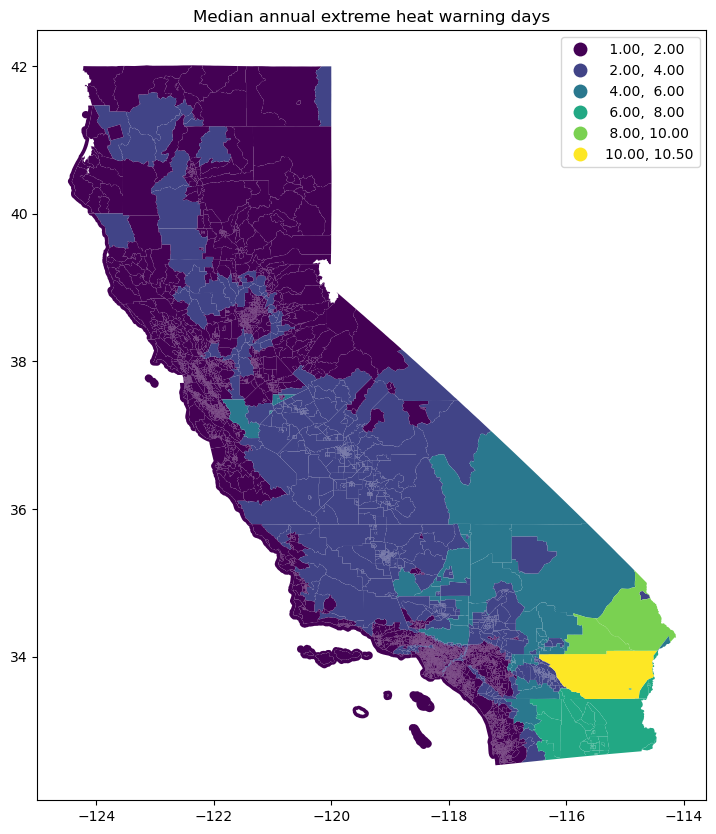

In [12]:
bins = [2,4,6,8,10]
fig, ax = plt.subplots(figsize=(10,10))
heat_gdf.plot(
    column="median_warning_days",
    legend=True,
    ax=ax,
    scheme='user_defined',
    classification_kwds={'bins': bins})
ax.set_title("Median annual extreme heat warning days")
plt.show()

In [13]:
merged_heat_data

,GEOID,median_warning_days,geometry
0,06085504321,1.0,"POLYGON ((-121.87556 37.39924, -121.87535 37.3..."
1,06085504410,1.0,"POLYGON ((-121.88886 37.40758, -121.88576 37.4..."
2,06085507003,1.0,"POLYGON ((-122.02489 37.21683, -122.02459 37.2..."
3,06085507004,1.0,"POLYGON ((-121.99304 37.22562, -121.99249 37.2..."
4,06085502204,1.0,"POLYGON ((-121.93167 37.29803, -121.92801 37.3..."
...,...,...,...
9124,06059001303,2.0,"POLYGON ((-117.95917 33.92458, -117.95888 33.9..."
9125,06059001304,2.0,"POLYGON ((-117.95918 33.92820, -117.95831 33.9..."
9126,06059001401,3.0,"POLYGON ((-117.95056 33.94503, -117.95055 33.9..."
9127,06013367200,1.5,"POLYGON ((-122.34551 37.96355, -122.34550 37.9..."


### Export the data

In [14]:
merged_heat_data = merged_heat_data.drop(columns={'geometry'})
merged_heat_data = merged_heat_data.rename(columns={'median_warning_days':'median_heat_warning_days'})

merged_heat_data.to_csv('climate_heat_warning_metric.csv', index=False)

## Function Call

In [16]:
@append_metadata
def isu_extreme_heat_warning_upload(input_csv, export=False, varname=''):
    '''
    Uploads the calculated extreme heat warning metric to S3 bucket. The metric is:
    Median number of excessive heat warnings days
    
    Data for this metric was sourced from ISU's Environmental Mesonet at:
    https://mesonet.agron.iastate.edu/request/gis/watchwarn.phtml

    Methods
    -------
    Data files were read in.
    Excessive heat warning date, location, and count columns were retained.
    Duplicate entries for a given location and date were dropped.
    Data was grouped by location and warning year.
    Number of warnings per year were summed per census tract.
    The median number of warnings were calculated for each census tract.
    
    Parameters
    ----------
    input_csv: string
        csv excessive heat warning data 
    export: True/False boolean
        False = will not upload resulting df containing CAL CRAI excessive heat warning metric to AWS
        True = will upload resulting df containing CAL CRAI excessive heat warning metric to AWS

    Script
    ------
    climate_risk_heat_warning.ipynb

    Note:
    This function assumes users have configured the AWS CLI such that their access key / secret key pair are stored in ~/.aws/credentials.
    See https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html for guidance.
    '''
    print('Data transformation: relevant metric columns were isolated.')
    print('Data transformation: duplicate entries per location and date were dropped.')
    print('Data transformation: GEOID 06075980401 (Farallon Islands, San Francisco County) filled with nan.') 
 
    if export == True:
        bucket_name = 'ca-climate-index'
        directory = '3_fair_data/index_data'
        export_filename = [input_csv]
        upload_csv_aws(export_filename, bucket_name, directory)

    if export == False:
        print(f'{input_csv} uploaded to AWS.')
 
    if os.path.exists(input_csv):
        os.remove(input_csv)

In [17]:
input_csv = 'climate_heat_warning_metric.csv'
varname = 'climate_iowa_mesonet_heat_warnings'

isu_extreme_heat_warning_upload(input_csv, export=True, varname='test')